#Згрузка данных

In [ ]:
!pip install catboost sklearn shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.2 MB/s 
     |████████████████████████████████| 569 kB 57.3 MB/s 
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=0ae83a928ab63da309f6c5f111a67fdf107dbe3795c0d1e51c565a8127f4cf1c
  Stored in directory: /root/.cache/pip/wheels/42/56/cc/4a8bf86613aafd5b7f1b310477667c1fca5c51c3ae4124a003
Successfully built sklearn


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.compose import ColumnTransformer

In [ ]:
from catboost import CatBoostRegressor
from sklearn.linear_model import SGDRegressor

In [ ]:
plt.style.use('dark_background')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/ml_data/japan_cars_auction/auction_cars_50k.csv')

In [ ]:
data.head(3)

,air_conditioner_type,auction_condition_rating,auction_date,auction_place,auction_start_price,body_model,car_color,car_model,car_year,drive_type,engine_displacement,horse_power,lot_number,odometer,sale_price,transmission_type
0,AAC,3.5,2022-11-02,MIRIVE Saitama,0,UCF30,CON,TOYOTA CELSIOR,2005,FR,4300,280.0,20017,0,453000,FAT
1,AAC,S,2022-11-02,CAA Chubu,2890000,GUN125,БРОНЗА,TOYOTA HILUX,2022,PARTTIME4WD,2400,150.0,36031,0,3710000,FAT
2,AAC,S,2022-11-02,CAA Chubu,1780000,MXPK11,ЧЕРНЫЙ,TOYOTA AQUA,2022,NaN,1500,NaN,36033,0,2325000,FAT


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   air_conditioner_type      49407 non-null  object 
 1   auction_condition_rating  50000 non-null  object 
 2   auction_date              50000 non-null  object 
 3   auction_place             50000 non-null  object 
 4   auction_start_price       50000 non-null  int64  
 5   body_model                50000 non-null  object 
 6   car_color                 49495 non-null  object 
 7   car_model                 50000 non-null  object 
 8   car_year                  50000 non-null  int64  
 9   drive_type                39483 non-null  object 
 10  engine_displacement       50000 non-null  int64  
 11  horse_power               39483 non-null  float64
 12  lot_number                50000 non-null  int64  
 13  odometer                  50000 non-null  int64  
 14  sale_p

In [ ]:
data['car_year'] = data['car_year'].astype('int')

In [ ]:
data['auction_date'] = pd.to_datetime(data['auction_date'])#, format='%Y.%m.%d')
data['auction_date'] = data['auction_date'].apply(lambda x: (x.year - 1980)*366+x.month*31+x.day)

Описание датасета 

* air_conditioner_type - тип кондиционера  
  (AC:Кондиционер, AAC:Климат-контроль, WAC:Двойной кондиционер)  

* auction_condition_rating - аукционная оценка  
  S - Новый автомобиль.  
  6 - Идеальное состояние (пробег менее 30000 км).  
  5 - Идеальное состояние (пробег менее 60000 км).
  4.5 - Хорошее состояние, минимальное количеством царапин и вмятин.  
  4 - Достаточно хорошее состояние, возможно нужен ремонт.  
  3.5 - Необходима восстановительная работа, или пробег выше среднего.  
  3 - Автомобиль имеет очевидные вмятины и царапины. Необходима восстановительная работа, или большой пробег.  
  2 - Плохое состояние.  
  1 - Плохое состояние (затопленный, поврежденный и т.п.)  
  R - Восстановленный после аварии.  
  RA - Восстановленный после тяжелой аварии.  
  *** (0, А, С, Т) - битые, авто на запчасти

* auction_date - дата проведения аукциона 
* auction_place - аукционная площадка  
* auction_start_price - начальная цена  
* body_model - модель автомобиля
* car_color - цвет автомобиля  
* car_model - модель авто  
* car_year - год производства  
* drive_type - тип привода  
  FF - перелний  
  FR - задний  
  FULLTIME4WD - постоянный полный привод  
  PARTTIME4WD - полный привод подключаемый  
* engine_displacement - объем двигателя  
* horse_power - мощность в л.с.  
* lot_number - номер лота  
* odometer - пробег  
* sale_price  - финальная цена
* transmission_type - коробка передач 

Заполнение пропусков 

In [ ]:
data.isnull().sum()

air_conditioner_type          593
auction_condition_rating        0
auction_date                    0
auction_place                   0
auction_start_price             0
body_model                      0
car_color                     505
car_model                       0
car_year                        0
drive_type                  10517
engine_displacement             0
horse_power                 10517
lot_number                      0
odometer                        0
sale_price                      0
transmission_type               0
dtype: int64

In [ ]:
data['air_conditioner_type'] = data['air_conditioner_type'].fillna(
    value=data['air_conditioner_type'].mode()[0])

In [ ]:
data['car_color'] = data['car_color'].fillna(
    value=data['car_color'].mode()[0])

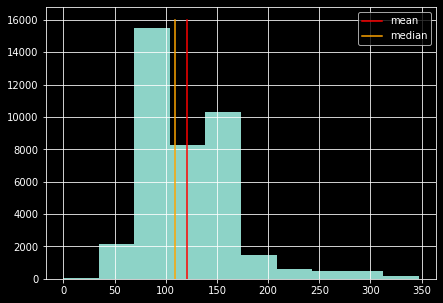

In [ ]:
plt.figure(figsize=(7,5))
data['horse_power'].hist()

y = np.linspace(0, 16000, 10)
plt.plot([np.mean(data['horse_power'])]*10, y, label='mean', color='r')
plt.plot([np.median(data[~data['horse_power'].isna()]['horse_power'])]*10, y, label='median', color='orange')

plt.legend()

In [ ]:
data['horse_power'] = data['horse_power'].fillna(np.mean(data['horse_power']))

In [ ]:
data['drive_type'].value_counts()

FF             32318
FULLTIME4WD     5265
FR              1738
PARTTIME4WD      162
Name: drive_type, dtype: int64

In [ ]:
data['drive_type'] = data['drive_type'].fillna(data['drive_type'].value_counts().index[0])

Выберем целевую переменную, выкинем номер лота

In [ ]:
X_lables = data.columns.drop(['lot_number', 'sale_price'])
target = 'sale_price'

In [ ]:
X_lables.values

array(['air_conditioner_type', 'auction_condition_rating', 'auction_date',
       'auction_place', 'auction_start_price', 'body_model', 'car_color',
       'car_model', 'car_year', 'drive_type', 'engine_displacement',
       'horse_power', 'odometer', 'transmission_type'], dtype=object)

In [ ]:
target

'sale_price'

Разобьем на трейн и тест со стратификацией по модели автомобиля 

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(data[X_lables], data[target], train_size=0.8, stratify=data['car_model'], random_state=17)

In [ ]:
y_train = y_train.reset_index(drop=True)

In [ ]:
y_valid = y_valid.reset_index(drop=True)

In [ ]:
X_train.shape, y_train.shape

((40000, 14), (40000,))

In [ ]:
X_valid.shape, y_valid.shape

((10000, 14), (10000,))

In [ ]:
X_train.isna().sum().sum(), y_train.isna().sum().sum(),\
X_valid.isna().sum().sum(), y_valid.isna().sum().sum()

(0, 0, 0, 0)

In [ ]:
X_train.to_csv('X_train.csv')
y_train.to_csv('y_train.csv')
X_valid.to_csv('X_valid.csv')
y_valid.to_csv('y_valid.csv')

#EDA

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 5

Анализ

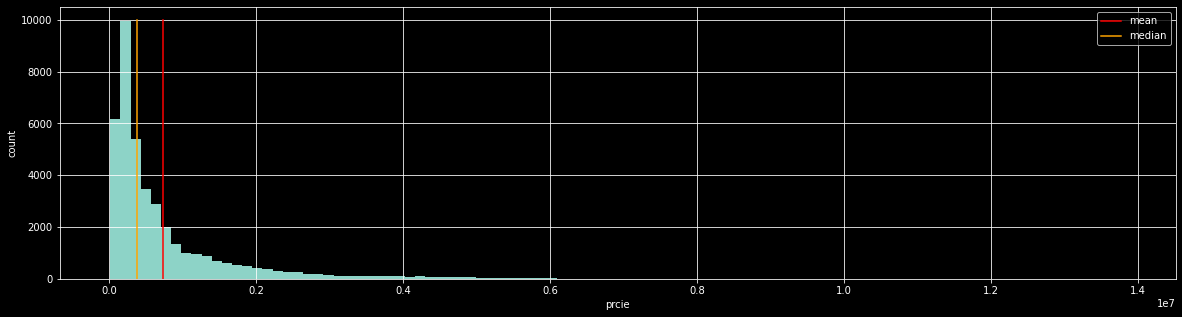

In [ ]:
y_train.hist(bins=100)
y = np.linspace(0, 10000, 10)
plt.plot([np.mean(y_train)]*10, y, label='mean', color='r')
plt.plot([np.median(y_train)]*10, y, label='median', color='orange')

plt.xlabel('prcie')
plt.ylabel('count')

plt.legend()

Имеем скошенное распределение целевой переменной, с жирным хвостом

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


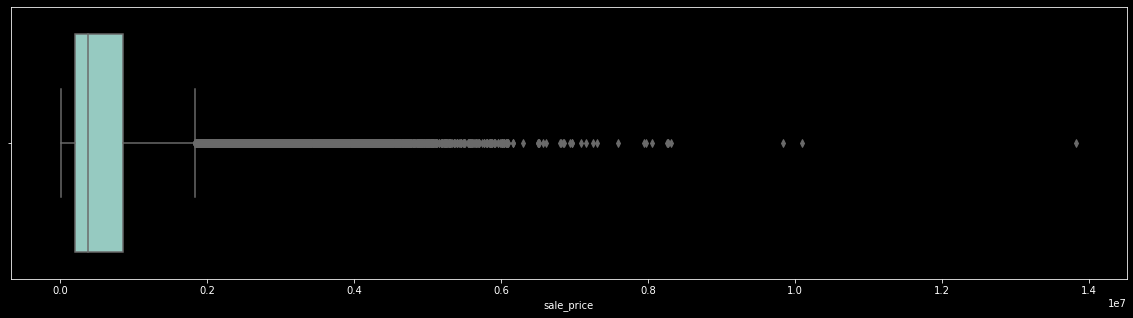

In [ ]:
sns.boxplot(y_train)

Возможно их надо будет обработать 

Text(0, 0.5, 'unique count')

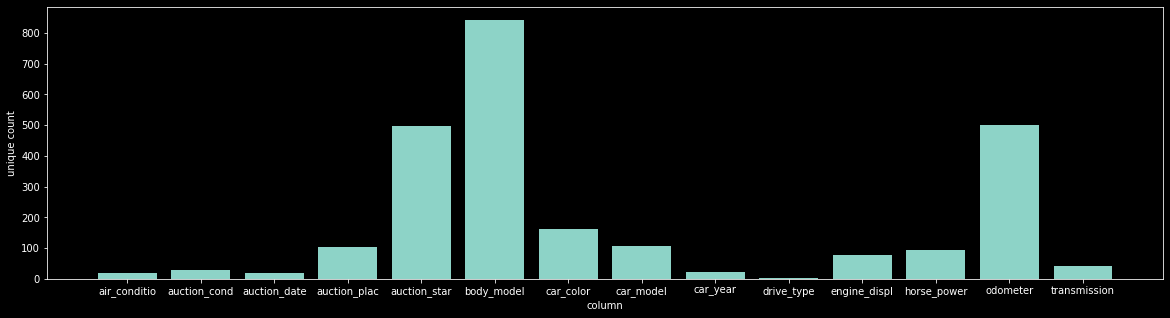

In [ ]:
x_col = X_train.columns
x_uniq = [X_train[c].nunique() for c in x_col]
plt.bar(pd.Series(x_col).apply(lambda x: x[:12]), x_uniq)
plt.xlabel('column')
plt.ylabel('unique count')

###air_conditioner_type

In [ ]:
X_train['air_conditioner_type'].value_counts()

AAC     22226
AC      16037
WAC      1023
WAA       288
OA        204
ﾌﾒｲ        58
ﾅｼ         47
WAAC       40
WA         20
C          11
DAAC       11
DAC        10
ｱﾘ          9
?           7
なし          4
AWA         3
W/AC        1
DAA         1
Name: air_conditioner_type, dtype: int64

Уберем маленькие группы

In [ ]:
class AirCondTypeTransformer(BaseEstimator, TransformerMixin):
  def __init__(self):
    pass

  def fit(self, x, y=None):
    self.air_cond_gr =  x['air_conditioner_type'].value_counts().index
    return self

  def transform(self, x, y=None):
    x['air_conditioner_type'] = x['air_conditioner_type'].apply(
        lambda x: x if x in self.air_cond_gr[:5] 
                    else self.air_cond_gr[np.random.randint(0,2)])
    return x

In [ ]:
cond_trans = AirCondTypeTransformer()
X_train = cond_trans.fit_transform(X_train)
X_valid = cond_trans.transform(X_valid)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


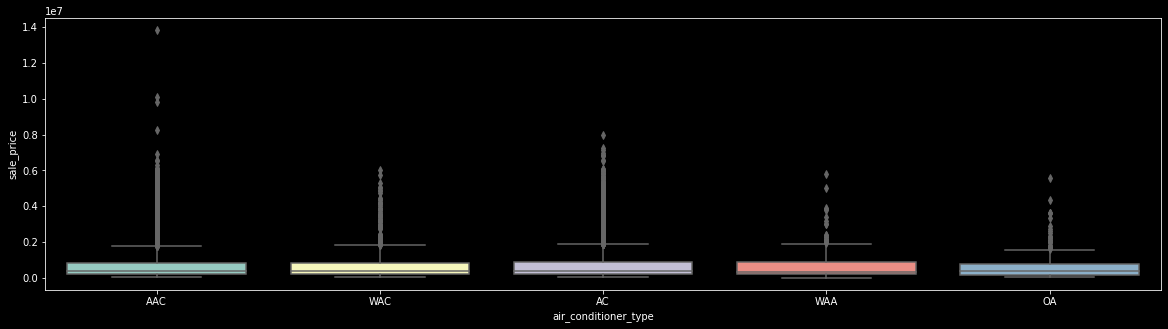

In [ ]:
plt.figure(figsize=(20, 5))
sns.boxplot(X_train['air_conditioner_type'], y_train)
plt.show()

Более развитые системы кондиционирования вносят больший вклад в стоимость 

### auction_condition_rating

In [ ]:
t = X_train['auction_condition_rating'].value_counts()
t

3.5    13786
4       8161
R       6381
3       3782
RA      2727
4.5     2524
5        769
         407
-        231
2        221
0        200
*        191
S        165
99       122
X        103
6         78
RB        52
***       46
1         34
G          5
R2         4
B          4
RC         2
WR         1
9          1
R1         1
0.         1
XX         1
Name: auction_condition_rating, dtype: int64

Уберем маленькие группы

In [ ]:
class AucCoundRaitingTransformer(BaseEstimator, TransformerMixin):
  def __init__(self):
    pass

  def fit(self, x, y=None):
    cond_gr =  x['auction_condition_rating'].value_counts()
    self.cond_rait_moda = cond_gr.keys()[0]
    self.cond_rait_smal_group = list(cond_gr[cond_gr<10].index)
    return self

  def transform(self, x, y=None):
    x.loc[x['auction_condition_rating'].isin(self.cond_rait_smal_group),
          'auction_condition_rating'] = self.cond_rait_moda
    x.loc[x['auction_condition_rating'].isin([' ', '-']), 'auction_condition_rating'] = 'Unnown'
    return x

In [ ]:
rating_trans = AucCoundRaitingTransformer()
X_train = rating_trans.fit_transform(X_train)
X_valid = rating_trans.transform(X_valid)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


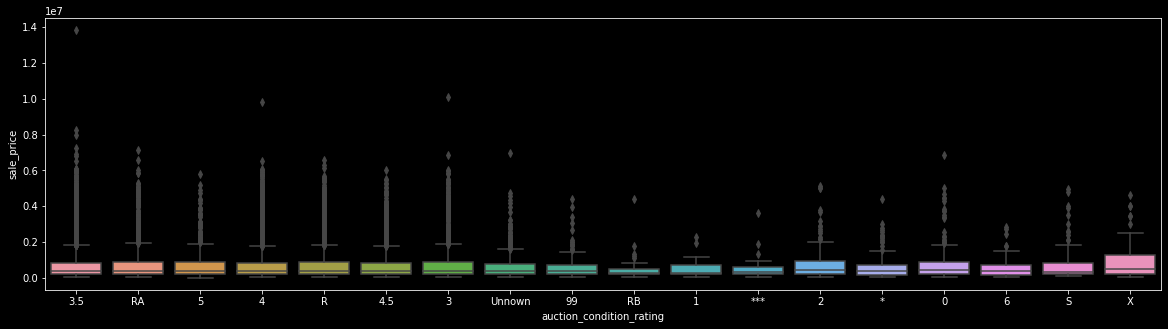

In [ ]:
plt.figure(figsize=(20, 5))
sns.boxplot(X_train['auction_condition_rating'], y_train, orient='v' )
plt.show()

### auction_start_price 

Возможно не самый честный признак тк есть утечка данных и сильная зависимость между начальной ценой и финальной ценой продажи  
Выкинем его

In [ ]:
print(f"Коэффициент корреляции Пирсона {round(np.corrcoef([X_train['auction_start_price'], y_train])[0][1],3)} ")

Коэффициент корреляции Пирсона 0.941 


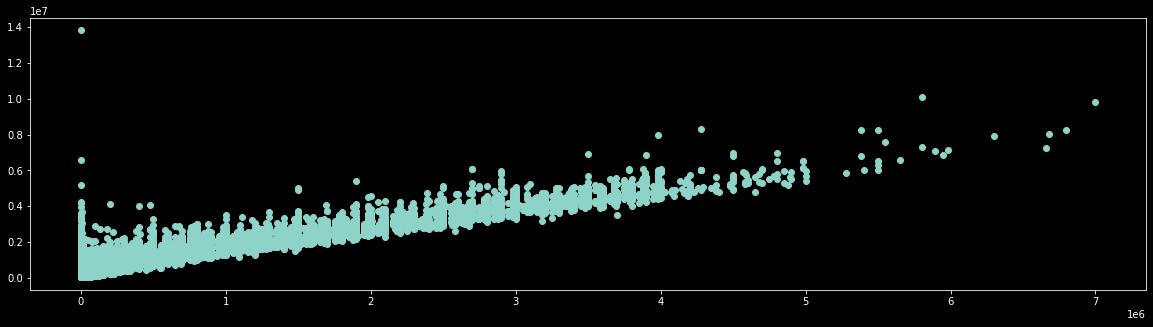

In [ ]:
plt.scatter(X_train['auction_start_price'], y_train)

### car_color

In [ ]:
X_train['car_color'].value_counts().head(10)

БЕЛЫЙ          13657
СЕРЕБРИСТЫЙ     8633
ЧЕРНЫЙ          7164
СЕРЫЙ           1610
OTHER           1511
СИНИЙ           1424
КРАСНЫЙ         1006
ПУРПУРНЫЙ        691
CON              444
ВИННЫЙ           399
Name: car_color, dtype: int64

In [ ]:
X_train['car_color'].value_counts()

БЕЛЫЙ                 13657
СЕРЕБРИСТЫЙ            8633
ЧЕРНЫЙ                 7164
СЕРЫЙ                  1610
OTHER                  1511
                      ...  
LIME GREEN                1
ЧЕРНО-СИНИЙ               1
LIGHT ROSE                1
TITANIUM GRAY             1
DARK BLUE METALLIC        1
Name: car_color, Length: 161, dtype: int64

Перекрасим все веселые машины в скучные 

In [ ]:
class ColorTransformer(BaseEstimator, TransformerMixin):
  def __init__(self):
    pass

  def fit(self, x, y=None):
    self.pop_colors = x['car_color'].value_counts().head(10)
    return self
    
  def transform(self, x, y=None):
    x['car_color'] = x['car_color'].apply(
        lambda x: x if x in self.pop_colors.keys()[:8] 
        else self.pop_colors.keys()[np.random.randint(0, 3)])
    return x

In [ ]:
col_trans = ColorTransformer()
X_train = col_trans.fit_transform(X_train)
X_valid = col_trans.transform(X_valid)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


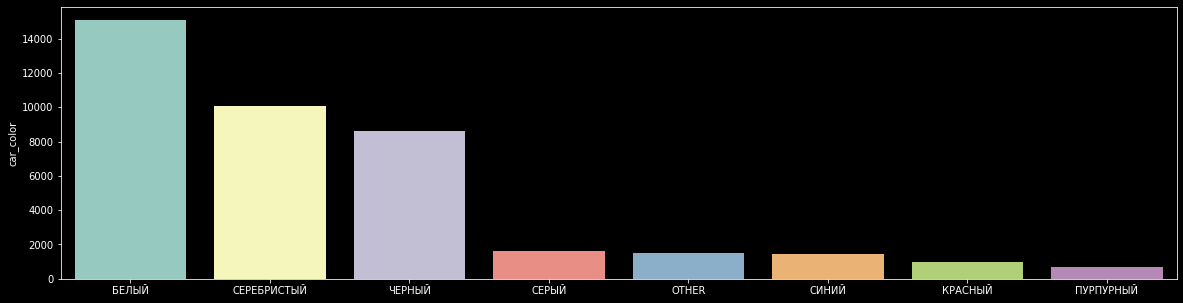

In [ ]:
sns.barplot(X_train['car_color'].value_counts().keys(),
            X_train['car_color'].value_counts())

###car_year

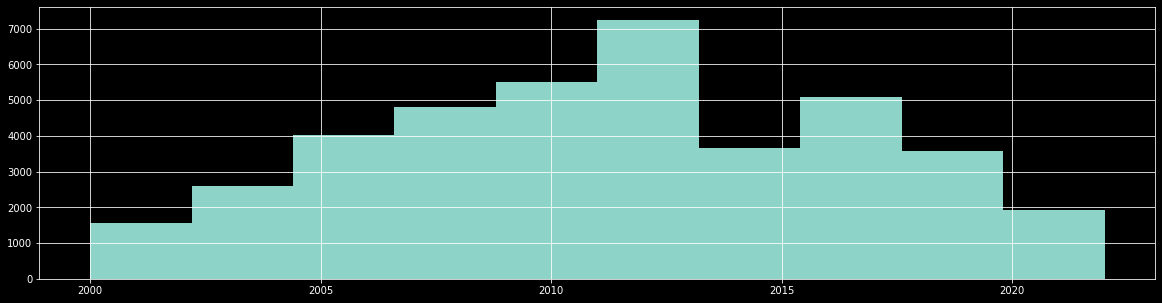

In [ ]:
X_train['car_year'].hist()

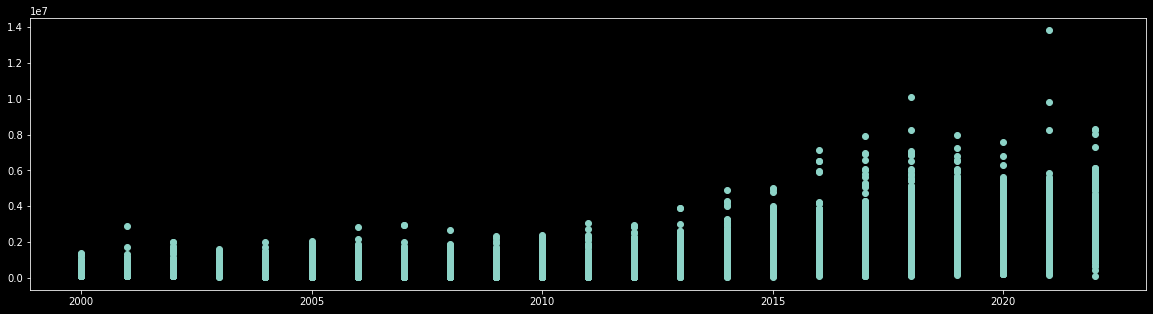

In [ ]:
plt.scatter(X_train['car_year'], y_train)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


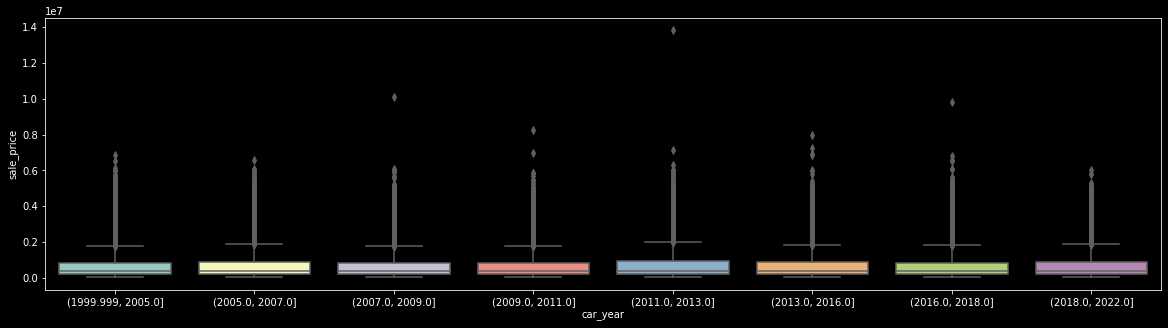

In [ ]:
sns.boxplot(pd.qcut(X_train['car_year'], 8), y_train)
plt.show();

In [ ]:
print(f"Коэффициент корреляции Пирсона {round(np.corrcoef([X_train['car_year'], y_train])[0][1],3)} ")

Коэффициент корреляции Пирсона 0.626 


Присутствует высокая корреляция между годом и ценой машины, занчит этот признак может быть не пхолим для построения модели

### drive_type

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


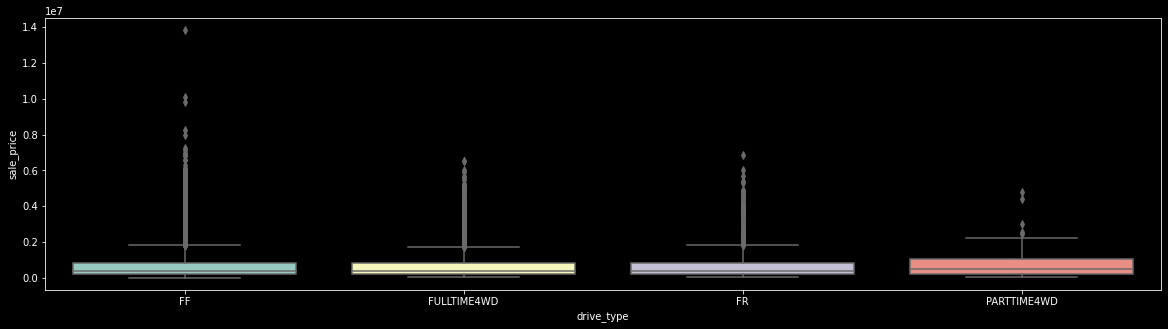

In [ ]:
sns.boxplot(X_train['drive_type'], y_train)

Также может быть не плохим признаком как минимум для класса PARTTIME4WD тк он имеет отдичное от остадьных классов распределение 

### engine_displacement

In [ ]:
print(f"Коэффициент корреляции Пирсона {round(np.corrcoef([X_train['engine_displacement'], y_train])[0][1],3)} ")

Коэффициент корреляции Пирсона 0.268 


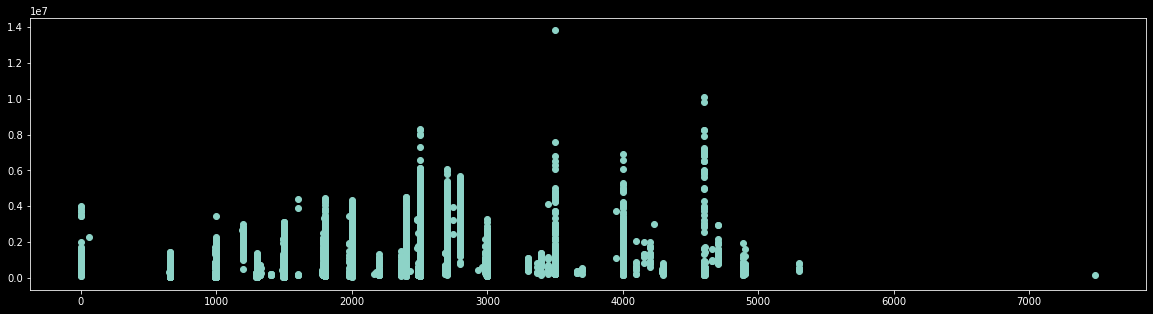

In [ ]:
plt.scatter(X_train['engine_displacement'], y_train)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


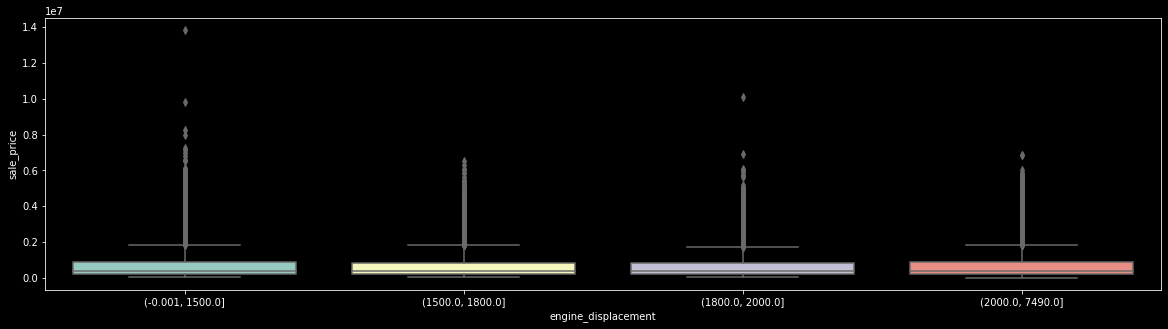

In [ ]:
sns.boxplot(pd.qcut(X_train['engine_displacement'], 4), y_train)
plt.show();

Корреляция присона имеет низкое значение, но на графике между объемом и ценой автомобиля можно заметит не линейную зависимость, которую не способна определить корреляция пирсона

### horse_power

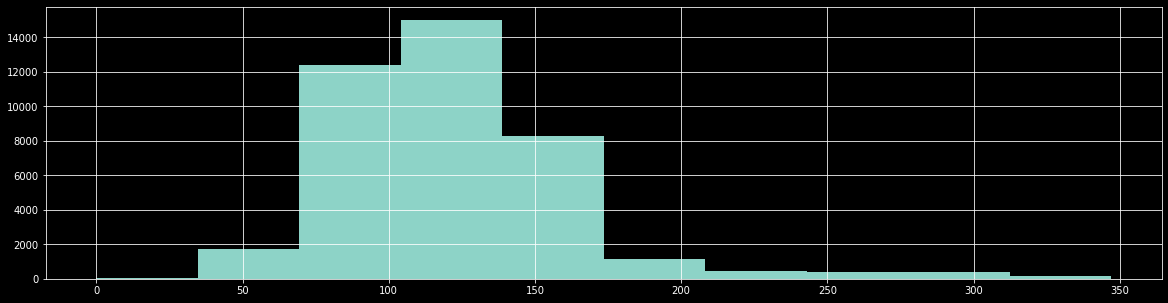

In [ ]:
X_train['horse_power'].hist()

In [ ]:
print(f"Коэффициент корреляции Пирсона {round(np.corrcoef([X_train['horse_power'], y_train])[0][1],3)} ")

Коэффициент корреляции Пирсона 0.221 


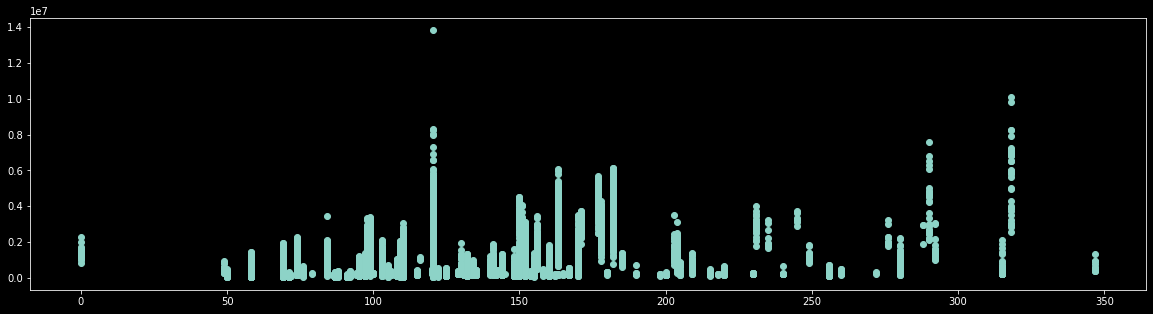

In [ ]:
plt.scatter(X_train['horse_power'], y_train)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


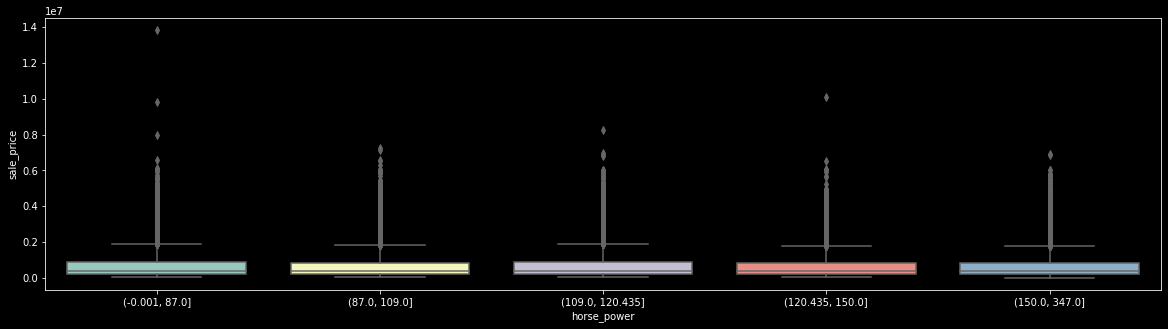

In [ ]:
sns.boxplot(pd.qcut(X_train['horse_power'], 5), y_train)
plt.show();

Также низкое значение корреляции тк нет сильной линейной зависимости, но можно заметить не линейную зависимость

### odometer

In [ ]:
print(f"Коэффициент корреляции Пирсона {round(np.corrcoef([X_train['odometer'], y_train])[0][1],3)} ")

Коэффициент корреляции Пирсона -0.405 


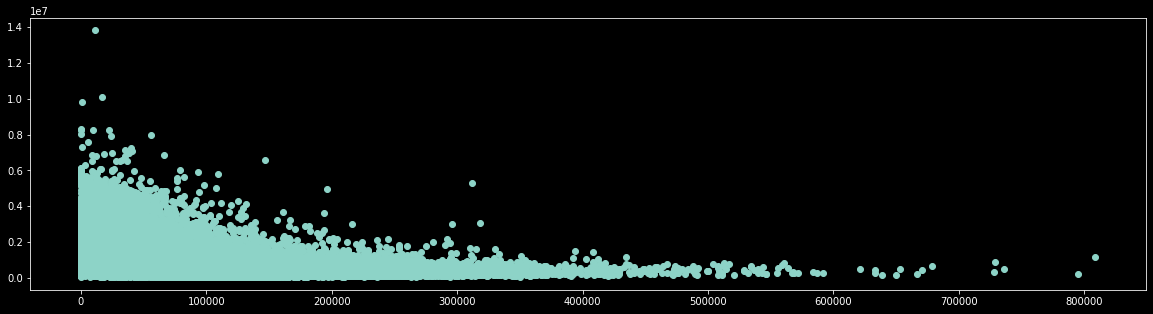

In [ ]:
plt.scatter(X_train['odometer'], y_train)

Между пробегом и финальной ценой есть высокая линейная зависимость, что также показывает коэффицент корреляции. Это может быть хорошим признаком для модели

###transmission_type

In [ ]:
X_train['transmission_type'].value_counts().head(20)

IAT      13078
FAT      11114
AT        9649
CAT       1661
DAT       1094
FA         780
F5         566
IA         426
DA         420
CA         318
           192
F6         139
PAT        114
MT         104
I5         103
5F          76
CVT         42
C5          33
FCVT        19
5           10
Name: transmission_type, dtype: int64

Откинем мальнькие группы

In [ ]:
class TransmissionTransformer(BaseEstimator, TransformerMixin):
  def __init__(self):
    pass
  
  def fit(self, x):
    t = X_train['transmission_type'].value_counts()
    self.main_group = t[t>100].keys()
    self.moda = t.keys()[0]
    return self
  
  def transform(self, x):
    x.loc[~x['transmission_type'].isin(self.main_group),
          'transmission_type'] = self.moda
    x.loc[x['transmission_type'].isin([' ', '-']), 'transmission_type'] = 'Unnown'
    return x

In [ ]:
transm_transf = TransmissionTransformer()
X_train = transm_transf.fit_transform(X_train)
X_valid = transm_transf.transform(X_valid)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


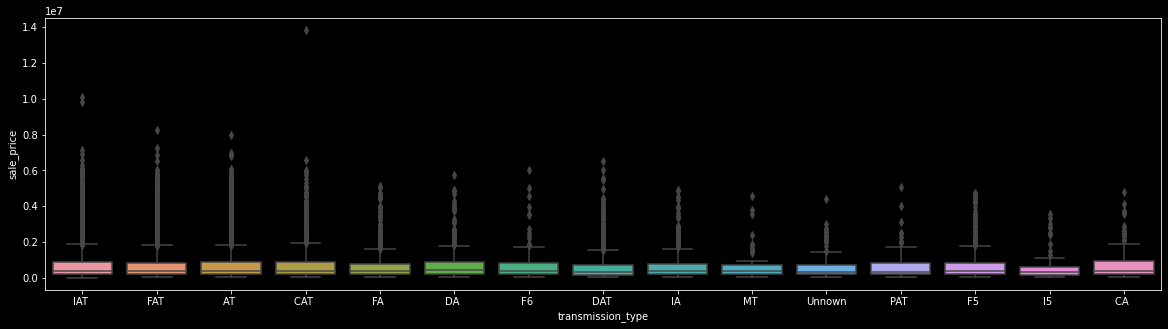

In [ ]:
sns.boxplot(X_train['transmission_type'], y_train)

Каких-то явынх отличий не заметно



#Predictions and model analytics


##catboost

In [ ]:
import catboost

In [ ]:
from catboost import Pool

In [ ]:
cat_features = ['air_conditioner_type',
                'auction_condition_rating',
                #'auction_date',
                'auction_place',
                #'auction_start_price',
                'body_model',
                'car_color',
                'car_model',
                #'car_year',
                'drive_type',
                #'engine_displacement',
                #'horse_power',
                #'odometer',
                'transmission_type',
                #'new_car'
                ]

In [ ]:
pool_train = Pool(X_train.drop(['auction_start_price'], axis=1), y_train, cat_features=cat_features)
pool_valid = Pool(X_valid.drop(['auction_start_price'], axis=1), y_valid, cat_features=cat_features)

pool_train.shape, pool_valid.shape

((40000, 13), (10000, 13))

In [ ]:
model = CatBoostRegressor(
    iterations=10000,
    learning_rate=0.5,
    #custom_metric=['MAE', 'MAPE'],
    task_type='GPU'
)
model.fit(pool_train,
          eval_set=pool_valid,
          #plot=True,
          verbose=500)

0:	learn: 566277.4025464	test: 563667.5839941	best: 563667.5839941 (0)	total: 151ms	remaining: 25m 11s
500:	learn: 161780.5256083	test: 197245.6773470	best: 197245.6773470 (500)	total: 23.2s	remaining: 7m 19s
1000:	learn: 152438.3618004	test: 194318.4965470	best: 194298.1195337 (997)	total: 37.7s	remaining: 5m 38s
1500:	learn: 146910.4503582	test: 194079.3291691	best: 193978.8884970 (1057)	total: 52.2s	remaining: 4m 55s
2000:	learn: 142696.0985733	test: 193531.5051838	best: 193497.5197809 (1996)	total: 1m 6s	remaining: 4m 24s
2500:	learn: 139668.5369640	test: 193048.0910165	best: 193011.4128098 (2493)	total: 1m 20s	remaining: 3m 59s
3000:	learn: 137328.7220818	test: 192884.8803441	best: 192773.2956255 (2663)	total: 1m 36s	remaining: 3m 43s
3500:	learn: 134295.6101538	test: 192732.2997550	best: 192534.5789653 (3395)	total: 1m 50s	remaining: 3m 24s
4000:	learn: 131804.7231531	test: 192793.5901421	best: 192534.5789653 (3395)	total: 2m 4s	remaining: 3m 6s
4500:	learn: 130067.7173588	test: 

In [ ]:
metr_train = model.eval_metrics(pool_train, metrics=['MAE', 'MAPE'])

In [ ]:
metr_valid = model.eval_metrics(pool_valid, metrics=['MAE', 'MAPE'])

In [ ]:
best_iter = model.best_iteration_

Text(0, 0.5, 'iteration')

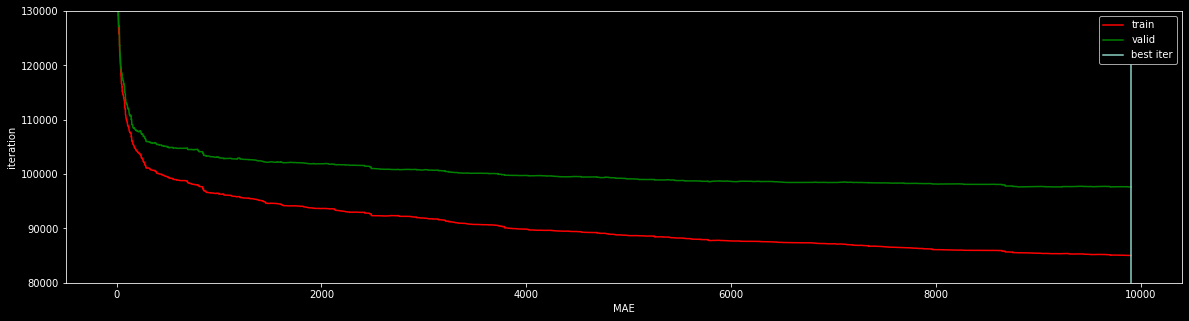

In [ ]:
plt.plot(metr_train['MAE'], color='r', label='train')
plt.plot(metr_valid['MAE'], color='g', label='valid')
plt.plot([best_iter]*10, np.linspace(0.8e5, 1.2e5, 10), label='best iter')
plt.legend()
plt.ylim(0.8e5, 1.3e5)
plt.xlabel('MAE')
plt.ylabel('iteration')

Text(0, 0.5, 'iteration')

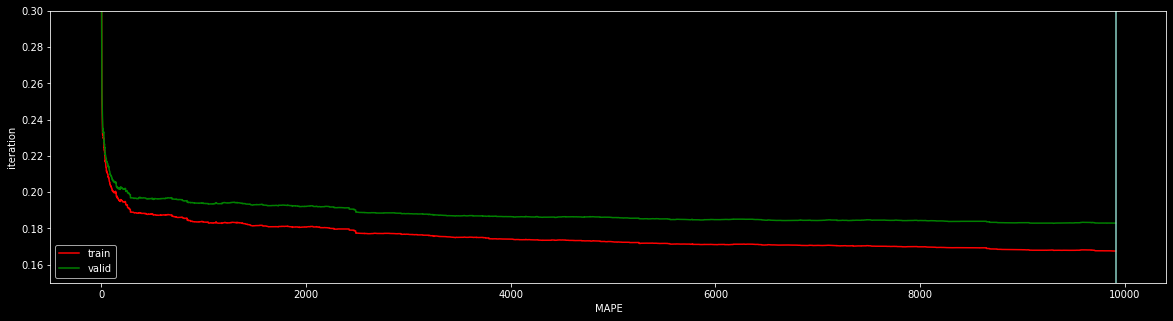

In [ ]:
plt.plot(metr_train['MAPE'], color='r', label='train')
plt.plot(metr_valid['MAPE'], color='g', label='valid')
plt.plot([best_iter]*10, np.linspace(0.15, 0.3, 10))
plt.legend()
plt.ylim(0.15, 0.3)
plt.xlabel('MAPE')
plt.ylabel('iteration')

In [ ]:
metr_valid['MAE'][-1], metr_valid['MAPE'][-1]

(97622.93634716418, 0.18294197544473012)

In [ ]:
cb_features = list(zip(model.feature_names_, model.feature_importances_))#.sort(key=lambda x: x[1], reverse=True)
cb_features.sort(key=lambda x: x[1], reverse=True)
cb_features

[('car_year', 31.34887308356889),
 ('engine_displacement', 30.389950614087756),
 ('odometer', 7.615010761140107),
 ('car_model', 6.841883853715382),
 ('horse_power', 6.702850719701346),
 ('auction_condition_rating', 6.632746094769842),
 ('body_model', 4.8384135367897585),
 ('drive_type', 2.163691367467505),
 ('air_conditioner_type', 1.5317371418853736),
 ('transmission_type', 0.7180447849723343),
 ('auction_place', 0.5611339100531844),
 ('car_color', 0.45725052292942947),
 ('auction_date', 0.19841360891888968)]

Переменные год выпуска и объем двигателя окзались самыми важными переменными для модели catboost, а самыми бесполезными оказались данные о месте проведения аукциона и его дате 

Подгрузим данные о кузове

In [ ]:
body_type = pd.read_csv('/content/drive/MyDrive/ml_data/japan_cars_auction/body_type.csv')

In [ ]:
X_train = X_train.merge(body_type, on='car_model', how='left')
X_train['body_type'] = X_train['body_type'].fillna('Unknown')
X_valid = X_valid.merge(body_type, on='car_model', how='left')
X_valid['body_type'] = X_valid['body_type'].fillna('Unknown')

In [ ]:
cat_features = ['air_conditioner_type',
                'auction_condition_rating',
                #'auction_date',
                'auction_place',
                #'auction_start_price',
                'body_model',
                'car_color',
                'car_model',
                #'car_year',
                'drive_type',
                #'engine_displacement',
                #'horse_power',
                #'odometer',
                'transmission_type',
                'body_type'
                ]

In [ ]:
pool_train = Pool(X_train.drop(['auction_start_price'], axis=1), y_train, cat_features=cat_features)
pool_valid = Pool(X_valid.drop(['auction_start_price'], axis=1), y_valid, cat_features=cat_features)

pool_train.shape, pool_valid.shape

((40000, 14), (10000, 14))

In [ ]:
model = CatBoostRegressor(
    iterations=10000,
    learning_rate=0.5,
    #custom_metric=['MAE', 'MAPE'],
    task_type='GPU',
)
model.fit(pool_train,
          eval_set=pool_valid,
          #plot=True,
          verbose=500)

0:	learn: 566007.3513716	test: 563758.7984847	best: 563758.7984847 (0)	total: 50.4ms	remaining: 8m 23s
500:	learn: 160532.3098449	test: 191681.7544852	best: 191604.1641234 (498)	total: 15.9s	remaining: 5m 1s
1000:	learn: 148435.1067029	test: 186625.9235369	best: 186566.9144363 (979)	total: 31s	remaining: 4m 38s
1500:	learn: 142564.7854762	test: 184847.5198980	best: 184769.1389704 (1495)	total: 48.7s	remaining: 4m 35s
2000:	learn: 138536.4570440	test: 185047.7514324	best: 184753.9110211 (1714)	total: 1m 3s	remaining: 4m 12s
2500:	learn: 135170.0976322	test: 184186.2398210	best: 184132.3896403 (2481)	total: 1m 17s	remaining: 3m 52s
3000:	learn: 132401.0632836	test: 184344.5925638	best: 183980.4109414 (2738)	total: 1m 32s	remaining: 3m 34s
3500:	learn: 130136.6240137	test: 183958.9070284	best: 183958.9070284 (3500)	total: 1m 46s	remaining: 3m 18s
4000:	learn: 127655.6563267	test: 183994.4081093	best: 183934.2720186 (3506)	total: 2m 1s	remaining: 3m 2s
4500:	learn: 125586.9068775	test: 183

In [ ]:
metr_train = model.eval_metrics(pool_train, metrics=['MAE', 'MAPE'])
metr_valid = model.eval_metrics(pool_valid, metrics=['MAE', 'MAPE'])

In [ ]:
metr_valid['MAE'][-1], metr_valid['MAPE'][-1]

(94066.78613118567, 0.17646468425487288)

In [ ]:
cb_features = list(zip(model.feature_names_, model.feature_importances_))
cb_features.sort(key=lambda x: x[1], reverse=True)
cb_features

[('car_year', 33.899214810671175),
 ('engine_displacement', 28.916066768328328),
 ('horse_power', 7.226698097661335),
 ('odometer', 6.523130423605107),
 ('car_model', 6.428590934677823),
 ('auction_condition_rating', 4.904168655323748),
 ('body_type', 3.413222819048681),
 ('body_model', 3.3156754500552976),
 ('drive_type', 2.161456333113483),
 ('air_conditioner_type', 1.254804641454993),
 ('transmission_type', 0.6330676278326861),
 ('car_color', 0.6328557382998273),
 ('auction_place', 0.4465886618943556),
 ('auction_date', 0.2444590380334577)]

Это немного, но помогло уменьшить ошибку

In [ ]:
X_train_err = X_train.copy()
X_train_err['sale_price'] = y_train.values.copy()
X_train_err['predict'] = model.predict(pool_train)
X_train_err['error'] = X_train_err['predict'] - X_train_err['sale_price']

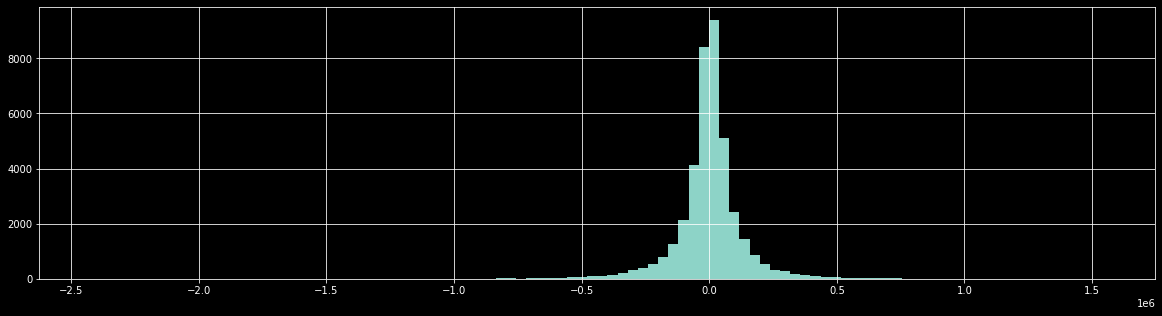

In [ ]:
X_train_err['error'].hist(bins=100)

Модель ошибается в большую и меньшую сторону примерно одинаково 

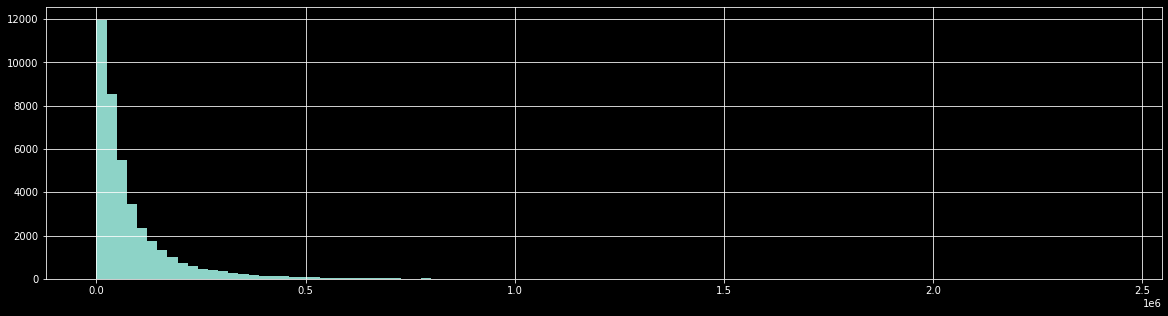

In [ ]:
abs(X_train_err['error']).hist(bins=100)

In [ ]:
X_train_err.sort_values(by='error', key=lambda x: np.abs(x), ascending=False).head(5)

,air_conditioner_type,auction_condition_rating,auction_date,auction_place,auction_start_price,body_model,car_color,car_model,car_year,drive_type,engine_displacement,horse_power,odometer,transmission_type,body_type,sale_price,predict,error
32985,AC,R,15700,ORIX Kobe Nyusatsu,0,M900A,ЧЕРНЫЙ,TOYOTA TANK,2019,FF,1000,84.000000,31000,AT,minivans,3450000,1.023869e+06,-2.426131e+06
9826,WAC,6,15696,MIRIVE Aichi,0,VJA300W,БЕЛЫЙ,TOYOTA LAND CRUISER,2021,FF,3500,120.435377,11000,FAT,suv,13820000,1.158324e+07,-2.236759e+06
25155,AC,3.5,15710,JU Miyagi,760000,KM85,БЕЛЫЙ,TOYOTA TOWN ACE TRUCK,2006,FF,1800,120.435377,73000,AT,minivans,2809000,6.570172e+05,-2.151983e+06
30367,AAC,3.5,15700,CAA Gifu,780000,RZJ95W,БЕЛЫЙ,TOYOTA LAND CRUISER PRADO,2001,FULLTIME4WD,2700,150.000000,179000,AT,suv,2901000,1.010031e+06,-1.890969e+06
2165,WAC,5,15715,CAA Chubu,4500000,URJ202W,СЕРЕБРИСТЫЙ,TOYOTA LAND CRUISER,2018,FULLTIME4WD,4600,318.000000,25000,FAT,suv,6970000,8.518995e+06,1.548995e+06


In [ ]:
import catboost
from catboost import *
import shap
shap.initjs()

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(pool_train)

In [ ]:
X_train_shap = X_train.drop(['auction_start_price'], axis=1).copy()

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[32985,:], X_train_shap.iloc[32985,:])

In [ ]:
print('mean price', 
      X_train_err[(X_train_err['body_model']=='M900A') & (X_train_err['car_model']=='TOYOTA TANK') & (X_train_err['car_year']==2019)]['sale_price'].mean())
X_train_err[(X_train_err['body_model']=='M900A') & (X_train_err['car_model']=='TOYOTA TANK') & (X_train_err['car_year']==2019)].sort_values(by='sale_price', ascending=False).head(5)

mean price 1099978.7234042552


,air_conditioner_type,auction_condition_rating,auction_date,auction_place,auction_start_price,body_model,car_color,car_model,car_year,drive_type,engine_displacement,horse_power,odometer,transmission_type,body_type,sale_price,predict,error
32985,AC,R,15700,ORIX Kobe Nyusatsu,0,M900A,ЧЕРНЫЙ,TOYOTA TANK,2019,FF,1000,84.0,31000,AT,minivans,3450000,1.023869e+06,-2.426131e+06
26713,AAC,5,15711,TAA Hyogo,380000,M900A,ЧЕРНЫЙ,TOYOTA TANK,2019,FF,1000,84.0,7000,IAT,minivans,1544000,1.413570e+06,-1.304305e+05
4046,AAC,4,15700,TAA Hiroshima,580000,M900A,БЕЛЫЙ,TOYOTA TANK,2019,FF,1000,84.0,11000,IAT,minivans,1528000,1.369501e+06,-1.584988e+05
5737,AAC,5,15697,JU Gifu,780000,M900A,БЕЛЫЙ,TOYOTA TANK,2019,FF,990,84.0,22000,AT,minivans,1460000,1.460801e+06,8.014361e+02
20320,AAC,4.5,15697,TAA Yokohama,580000,M900A,СЕРЕБРИСТЫЙ,TOYOTA TANK,2019,FF,1000,84.0,7000,IAT,minivans,1444000,1.360907e+06,-8.309328e+04


Эта машины была продана дороже в 3 раза, чем в среднем такие же модели этого года и в 2 раза дроже следующей по цене

In [ ]:
t = X_train_err.copy()
t['price_gr'] = pd.qcut(t['sale_price'], 5)
t['error_abs'] = np.abs(t['error'])
t = t.groupby('price_gr')['error_abs', 'error'].agg(['mean', 'sum'])
t.columns = ['_'.join(col).strip() for col in t.columns.values]
t['MAPE'] = [t.iloc[ind,0]/((i.left+i.right)/2) for ind, i in enumerate(t.index)]
t

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


,error_abs_mean,error_abs_sum,error_mean,error_sum,MAPE
price_gr,,,,,
"(17999.999, 177000.0]",30150.164522,2.423772e+08,11971.235327,9.623676e+07,0.309232
"(177000.0, 291000.0]",41083.652066,3.276010e+08,12573.861147,1.002640e+08,0.175571
"(291000.0, 523000.0]",63821.411726,5.110180e+08,7050.597990,5.645414e+07,0.156809
"(523000.0, 1095000.0]",99459.019107,7.937824e+08,3279.910315,2.617696e+07,0.122941
"(1095000.0, 13820000.0]",180936.600090,1.447312e+09,-31920.721547,-2.553339e+08,0.024262


In [ ]:
np.mean(t['error_abs_mean'])

83090.16950214173

In [ ]:
np.mean(t['MAPE'])

0.15776320883653835

Модель сильно ошибается на дорогих автомобилях, что сильно сказывается на метрике  MAE  
Но при этом в процентном соотношении модель сильнее ошибается на болле дешевых лотах, что влияет на оценку MAPE

##lr

In [ ]:
X_train = pd.read_csv('X_train.csv')
X_train = X_train.set_index('Unnamed: 0')
X_train.index.names = [None]
X_train.drop('auction_start_price', axis=1, inplace=True)

y_train = pd.read_csv('y_train.csv')
y_train = y_train.set_index('Unnamed: 0')
y_train.index.names = [None]

X_valid = pd.read_csv('X_valid.csv')
X_valid = X_valid.set_index('Unnamed: 0')
X_valid.index.names = [None]
X_valid.drop('auction_start_price', axis=1, inplace=True)

y_valid = pd.read_csv('y_valid.csv')
y_valid = y_valid.set_index('Unnamed: 0')
y_valid.index.names = [None]

In [ ]:
cat_features = [#'air_conditioner_type',
                #'auction_condition_rating',
                'auction_place',
                'body_model',
                #'car_color',
                'car_model',
                'drive_type',
                'transmission_type']

In [ ]:
num_features = ['auction_date',
                #'auction_start_price',
                'car_year',
                'engine_displacement',
                'horse_power',
                'odometer',
                ]

In [ ]:
air_cond_trans = Pipeline(steps=[
    ('air_cond', AirCondTypeTransformer()),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

In [ ]:
auc_rait_trans = Pipeline(steps=[
    ('auc_rait', AucCoundRaitingTransformer()),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

In [ ]:
color_trans = Pipeline(steps=[
    ('color_trans', ColorTransformer()),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

In [ ]:
trans = ColumnTransformer(
    transformers=[
        ('air_cond_trans', air_cond_trans, ['air_conditioner_type']),
        ('auc_rait_trans', auc_rait_trans, ['auction_condition_rating']),
        ('color_trans', color_trans, ['car_color']), 
        ('ohe', OneHotEncoder(handle_unknown='ignore'), cat_features),
        ('std_sc', StandardScaler(), num_features) 
    ])
fin_pipe = Pipeline(steps=[('trans', trans),
                           ('sgd', SGDRegressor(max_iter=10000,
                                               eta0=0.001
                                               ))])

In [ ]:
fin_pipe.fit(X_train, y_train)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Pipeline(steps=[('trans',
                 ColumnTransformer(transformers=[('air_cond_trans',
                                                  Pipeline(steps=[('air_cond',
                                                                   AirCondTypeTransformer()),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['air_conditioner_type']),
                                                 ('auc_rait_trans',
                                                  Pipeline(steps=[('auc_rait',
                                                                   AucCoundRaitingTransformer()),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                           

In [ ]:
y_train_pred = fin_pipe.predict(X_train)
y_valid_pred = fin_pipe.predict(X_valid)

In [ ]:
mean_absolute_error(y_train, y_train_pred),\
mean_absolute_percentage_error(y_train, y_train_pred)

(165180.215218613, 0.4475878663910422)

In [ ]:
mean_absolute_error(y_valid, y_valid_pred),\
mean_absolute_percentage_error(y_valid, y_valid_pred)

(164592.70946530666, 0.45155624827847435)

In [ ]:
t = pd.concat([y_valid, pd.Series(y_valid_pred)], axis=1)
t.columns = ['sale_price', 'pred_price_lr']
t['err_lr'] = t['pred_price_lr'] - t['sale_price']
t['err_lr_abs'] = np.abs(t['err_lr'])
t['pred_price_cb'] = model.predict(pool_valid)
t['err_cb'] = t['pred_price_cb'] - t['sale_price']
t['err_cb_abs'] = np.abs(t['err_cb'])
t.sort_values(by='err_lr_abs', ascending=False).head(10)

,sale_price,pred_price_lr,err_lr,err_lr_abs,pred_price_cb,err_cb,err_cb_abs
6057,13007000,4.252369e+06,-8.754631e+06,8.754631e+06,5.483199e+06,-7.523801e+06,7.523801e+06
8747,6020000,3.490218e+06,-2.529782e+06,2.529782e+06,4.349225e+06,-1.670775e+06,1.670775e+06
8619,4316000,2.124919e+06,-2.191081e+06,2.191081e+06,2.756123e+06,-1.559877e+06,1.559877e+06
2098,4236000,2.088441e+06,-2.147559e+06,2.147559e+06,4.367998e+06,1.319979e+05,1.319979e+05
2771,2812000,4.931836e+06,2.119836e+06,2.119836e+06,3.131728e+06,3.197277e+05,3.197277e+05
2222,3053000,5.143922e+06,2.090922e+06,2.090922e+06,3.879587e+06,8.265866e+05,8.265866e+05
4298,3302000,1.353756e+06,-1.948244e+06,1.948244e+06,3.199952e+06,-1.020479e+05,1.020479e+05
3505,5301000,3.367994e+06,-1.933006e+06,1.933006e+06,4.852769e+06,-4.482314e+05,4.482314e+05
6183,2024000,3.953711e+06,1.929711e+06,1.929711e+06,2.711348e+06,6.873475e+05,6.873475e+05
1881,5493000,3.586251e+06,-1.906749e+06,1.906749e+06,5.028599e+06,-4.644008e+05,4.644008e+05


In [ ]:
np.mean(t['err_lr'])

-2424.8084313747518

lr mean err = -2424.8084313747518
см mean err = 2204.136094102847


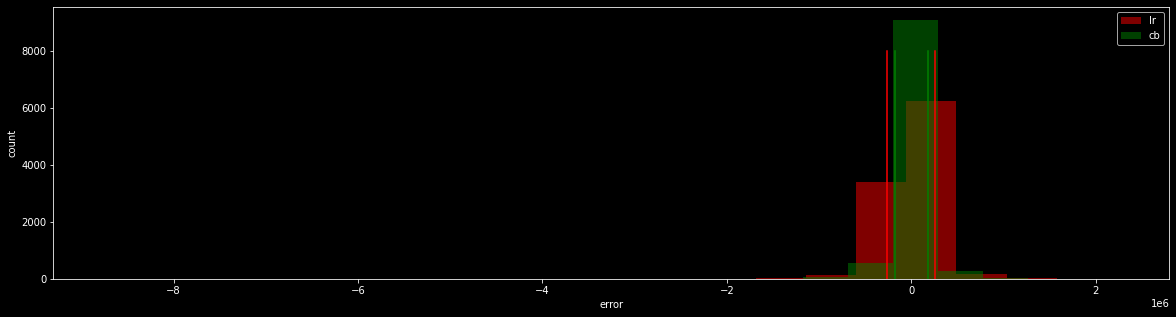

In [ ]:
y = np.linspace(0, 8000, 10)

plt.hist(t['err_lr'], bins=20, color='r', label='lr', alpha = 0.5)
plt.plot([np.mean(t['err_lr'] + np.std(t['err_lr']))]*10, y,color='r')
plt.plot([np.mean(t['err_lr'] - np.std(t['err_lr']))]*10, y,color='r')

plt.hist(t['err_cb'], bins=20, color='g', label='cb', alpha = 0.5)
plt.plot([np.mean(t['err_cb'] + np.std(t['err_cb']))]*10, y,color='g')
plt.plot([np.mean(t['err_cb'] - np.std(t['err_cb']))]*10, y,color='g')

plt.xlabel('error')
plt.ylabel('count')
plt.legend()

lr_mean_err = np.mean(t['err_lr'])
cb_mean_err = np.mean(t['err_cb'])
print(f'lr mean err = {lr_mean_err}')
print(f'см mean err = {cb_mean_err}')

Модель градаентного бустинка имеет меньшую среднюю ошибку и меньшее стандартное отклонение 